In [7]:
# Importing Necessary Libraries 

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import torchvision
import shutil
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

## **Step 1: Brief Description of the Problem and Data** 

The challenge in this project is to create a GAN model that can generate 7000 to 10,000 Monet style images from photos provided in the dataset. The metric used for evaluating performance is Memorization-informed Fréchet Inception Distance (MiFID). The images must be submitted in jpg format and the size should be 256 x 256 x 256. 

In terms of a brief description of GANs...A GAN has at least 2 neural networks. One must be a generator which creates the images. The generator is trained by a descriminator model. The two essentially work in opposition to one another. 

Step 2: Exploratory Data Analysis-Inspect, Visualize and Clean the Data does not seem to be required for this project. The rubric does not stipulate inclusion of this section. However there is some brief exploration and visualization below. 

Step 3: Describe Model Architecture also does not seem to be directly applicable here, however I have provided some commentary on model architecture and strategy below. 

In [8]:

class PaintingsDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
    
    def __get_crude_item__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        return image

Below are the hyperparameters. I tuned the hyperparameters during training to attempt to reduce overfitting. 

In [24]:
# Device and tensors configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

# Hyperparameters
batch_size = 6
lr = 0.0001
beta1 = 0.56
beta2 = 0.992
n_epoches = 10
display_epoch = 2


In [11]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),

    # Data augmentation 
    #transforms.ElasticTransform(alpha=150.0),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3.)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.15, 0.15, 0.15], std=[0.5, 0.5, 0.5])
])


In [13]:
# Initialize datasets

monet_dataset = PaintingsDataset('/kaggle/input/gan-getting-started/monet_jpg', transform)
photo_dataset = PaintingsDataset('/kaggle/input/gan-getting-started/photo_jpg', transform)

In [14]:
# Initialize data loaders

monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)

In [15]:
def show_images(n, dataset):
    ex_im_transf = dataset.__getitem__(n)
    ex_im_crude  = dataset.__get_crude_item__(n)

    im_transf = np.squeeze(ex_im_transf) 
    im_crude = np.squeeze(ex_im_crude)

    f, axarr = plt.subplots(1,2)

    for i in range(2):
        axarr[i].axes.get_xaxis().set_visible(False)
        axarr[i].axes.get_yaxis().set_visible(False)

    axarr[1].imshow(im_transf.permute(1, 2, 0))
    axarr[0].imshow(im_crude)
    axarr[1].set_title("Transformed image")
    axarr[0].set_title("Original image")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


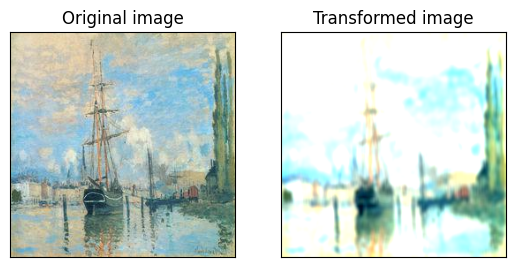

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


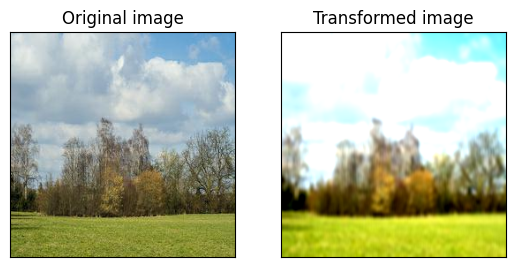

In [16]:
# Visualize data augmentation in both datasets

randn = random.randint(1,298)
show_images(n=randn, dataset=monet_dataset)
show_images(n=randn, dataset=photo_dataset)

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
    
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            # using ReLU instead of LeakyReLU for faster processing, data is relatively clean and has few outliers.
            nn.ReLU(inplace=True),
        
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            # IstanceNorm because we are using few n in batch
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),   
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),   
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

            
        )

    def forward(self, x):
        return self.model(x)
    

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.InstanceNorm2d(256)
        )

    def forward(self, x):
        return x + self.block(x)


In [19]:
class Generator(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(
            
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 2 * 3 + 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
            
        )

        self.downsample_blocks = nn.Sequential(
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
            
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock() for _ in range(num_residual_blocks)])

        self.upsample_blocks = nn.Sequential(
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),   
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
            
        )

        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 2 * 3 + 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)

In [20]:
G = Generator()
D = Discriminator()

models = [G, D]
for model in models:
    if torch.cuda.is_available():
        model.cuda()
        
gan_loss = nn.MSELoss().cuda()
cycle_loss = nn.L1Loss().cuda()
identity_loss = nn.L1Loss().cuda()

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

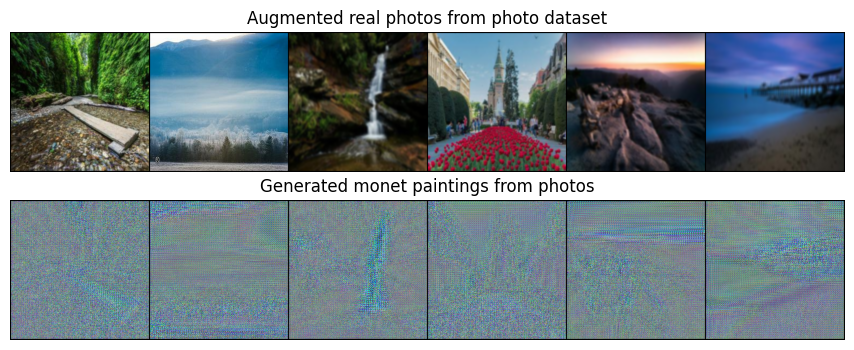

In [21]:
def sample_images(real_X):    
    # turn off some learning parameters in order to evaluate model:
    G.eval()
    
    # transform to tensor and plot images
    real_pic = real_X.type(Tensor)
    artificial_pic = G(real_X).detach()

    ncols = real_X.size(0)
    real_pic_grid = make_grid(real_pic, nrow=ncols, normalize=True)
    artificial_pic_grid = make_grid(artificial_pic, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(2, 1, figsize=(20, 4))  

    axs[0].imshow(real_pic_grid.permute(1, 2, 0).cpu())
    axs[0].set_title("Augmented real photos from photo dataset")
    axs[0].axis('off')

    axs[1].imshow(artificial_pic_grid.permute(1, 2, 0).cpu())
    axs[1].set_title("Generated monet paintings from photos")
    axs[1].axis('off')


    plt.show()

real_X = next(iter(photo_loader))
real_Y = next(iter(photo_loader))
sample_images(real_X.to(device))


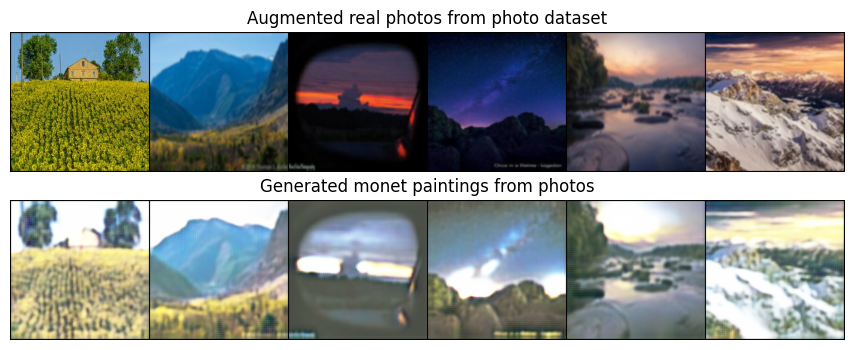

Epoch 2 | 10
Generator loss: 1.0854226350784302 =  0.8005743473768234 (5 * identity loss) + 0.28484827280044556 (GAN loss)
Discriminator loss: 0.25324684381484985 = 0.13368670642375946 (real monet loss/2)  + 0.2391202449798584 (generated monet loss/2)


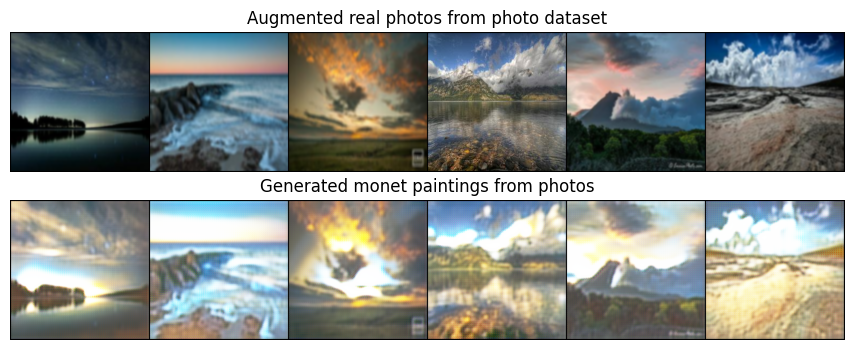

Epoch 4 | 10
Generator loss: 1.2352936267852783 =  0.868181511759758 (5 * identity loss) + 0.3671121299266815 (GAN loss)
Discriminator loss: 0.20619168877601624 = 0.11617956310510635 (real monet loss/2)  + 0.18002425134181976 (generated monet loss/2)


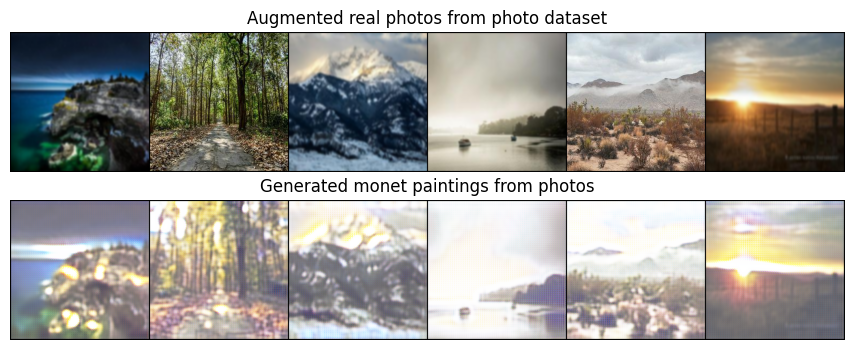

Epoch 6 | 10
Generator loss: 1.5828262567520142 =  1.3576692342758179 (5 * identity loss) + 0.2251570075750351 (GAN loss)
Discriminator loss: 0.2289579063653946 = 0.05270560458302498 (real monet loss/2)  + 0.3525046110153198 (generated monet loss/2)


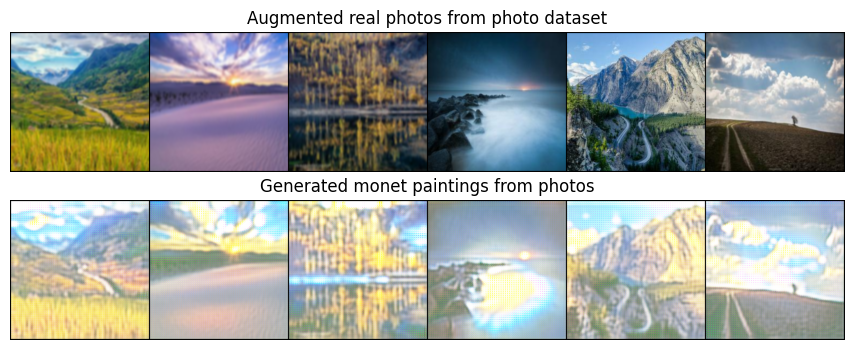

Epoch 8 | 10
Generator loss: 1.4689853191375732 =  1.2040991336107254 (5 * identity loss) + 0.26488611102104187 (GAN loss)
Discriminator loss: 0.19298627972602844 = 0.05179883912205696 (real monet loss/2)  + 0.28237488865852356 (generated monet loss/2)


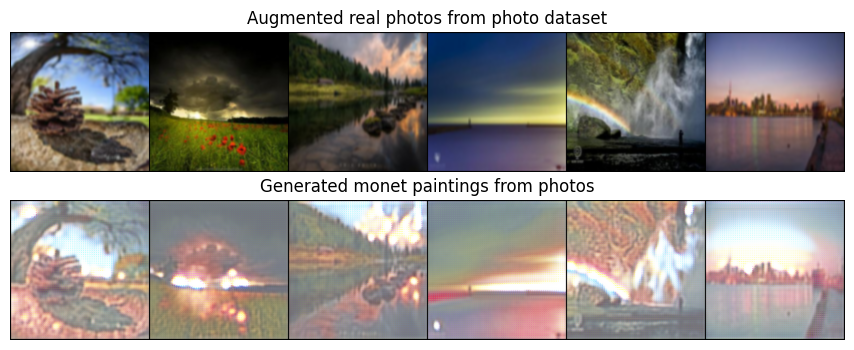

Epoch 10 | 10
Generator loss: 1.4419515132904053 =  1.024974286556244 (5 * identity loss) + 0.4169771373271942 (GAN loss)
Discriminator loss: 0.13941575586795807 = 0.062386754900217056 (real monet loss/2)  + 0.15405800938606262 (generated monet loss/2)


In [25]:
for epoch in range(n_epoches):
    for i, (real_photo, real_monet) in enumerate(zip(photo_loader, monet_loader)):

        real_photo = real_photo.type(Tensor)
        real_monet = real_monet.type(Tensor)
        
        out_shape = [real_photo.size(0), 1, real_photo.size(2) , real_photo.size(3)]
        
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        
        # training generator
        G.train()
        optimizer_G.zero_grad()
        artificial_monet = G(real_photo)

        
        # identity loss
        loss_identity = identity_loss(artificial_monet, real_photo)
        
        # gan loss
        loss_GAN = gan_loss(D(artificial_monet), valid) 
        
        # total gan loss
        loss_G = 5.0 * loss_identity + loss_GAN 
        
        loss_G.backward()
        optimizer_G.step()
        
        # training discriminator 
        optimizer_D.zero_grad()
        
        # real painting misclassification loss
        loss_real = gan_loss(D(real_monet), valid)
        
        # artificial painting misclassification loss
        loss_fake = gan_loss(D(artificial_monet.detach()), fake)
        loss_D = (loss_real + loss_fake) / 2
        
        loss_D.backward()
        optimizer_D.step()
    
    # sample results every n=display_epoch
    
    if (epoch + 1) % display_epoch == 0:
        test_real_photo, test_real_monet = next(iter(zip(photo_loader, monet_loader)))
        sample_images(test_real_photo.type(Tensor))

        print(f'Epoch {epoch + 1} | {n_epoches}')
        print(f'Generator loss: {loss_G.item()} =  {5 * loss_identity.item()} (5 * identity loss) + {loss_GAN.item()} (GAN loss)')
        print(f'Discriminator loss: {loss_D.item()} = {loss_real.item()/2} (real monet loss/2)  + {loss_fake.item()} (generated monet loss/2)')


In [26]:
# create path to save created monet paintings
transformed_save_dir = '../images'
if not os.path.exists(transformed_save_dir):
    os.makedirs(transformed_save_dir)
    
# freeze some network params to generate imgs
G.eval()


for i, real_photos in enumerate(photo_loader):
    real_photos = real_photos.to(device)
    with torch.no_grad():
        monet_style_imgs = G(real_photos)

    # Save each transformed image
    for j, img in enumerate(monet_style_imgs):
        save_path = os.path.join(transformed_save_dir, f'monet_painting_{i * batch_size + j}.png')
        torchvision.utils.save_image(img, save_path)

print(f"Transformed images are saved in {transformed_save_dir}")

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

Transformed images are saved in ../images


'/kaggle/working/images.zip'

Step 4: Results and Analysis also seems to not be relevant here. However, there are some visualizations above of the augmented real photos from the dataset and the generated "Monet paintings." As with the previous weekly peer-review assignments, training with only 10 epochs was not ideal, but it was the best option given the time constraints. 

Step 5: Conclusion: This is a fairly simple implementation of a GAN. The goal was to create a general model with higher complexity in relation to the discriminator model. Metrics used included MSE and L1 loss. In the network training, there were 2 parts to the generator losses, identity and GAN. The same was true for the discriminator model loss, which included real painting misclassification loss and artificial painting misclassification loss. Overall, this was a great project and a good learning experience. Some key takeaways were the large number of methods available for implementing a GAN and the importance of hyperparameter tuning and appropriate metric selection. As always with these weekly assignments, future improvements include training with more epochs and spending more time fine-tuning hyperparameters.  